In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


img = torch.randn([16, 1, 28, 28])

in_channels = 1
embed_dim = 32
patch_size = 4
num_patches = 49
dropout = 0.1

# Returns a patched output of size [batch, embed_dim, patches_row, patches_col]
patcher = nn.Sequential(
    nn.Conv2d(
        in_channels=in_channels,
        out_channels=embed_dim,
        kernel_size=patch_size,
        stride=patch_size,
    ),
    nn.Flatten(2)
)


print("image and patched")
print(img.shape)
x = patcher(img).permute(0, 2, 1)
print(x.shape)

cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
pos_embedding = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True) # +1 for cls token
dropout = nn.Dropout(p=dropout)

print("\ncls-tokens")
print(cls_token.shape)
cls_token2 = cls_token.expand(x.shape[0], -1, -1)
print(cls_token2.shape)

print("\ncls + x")
x = torch.cat((cls_token2, x), dim=1)
print(x.shape)


print("\n pos embedding + x")
x += pos_embedding
print(x.shape)


image and patched
torch.Size([16, 1, 28, 28])
torch.Size([16, 49, 32])

cls-tokens
torch.Size([1, 1, 32])
torch.Size([16, 1, 32])

cls + x
torch.Size([16, 50, 32])

 pos embedding + x
torch.Size([16, 50, 32])


In [25]:
from utils import SelfAttention, MultiHeadAttention

# Test self-attention
self_attention = SelfAttention(embed_dim=32, key_dim=64)


attention_scores = self_attention(x)
print(attention_scores.shape)



torch.Size([16, 50, 64])


In [26]:
# Multi-head attention
n_head = 4

# init multi-head self-attention
multi_head_attention = MultiHeadAttention(32, n_head)

# compute MSA score
print(x.shape)
attention_score = multi_head_attention(x)

print(attention_score.shape)
print(attention_score[0])

torch.Size([16, 50, 32])
torch.Size([16, 50, 32])
tensor([[-0.8286, -0.7417,  0.2358,  ..., -1.4929, -0.2309,  0.6467],
        [-0.6550,  0.7041,  0.4896,  ..., -0.4024,  0.5253,  0.6545],
        [ 0.0037,  0.9262,  0.3515,  ..., -0.6402,  1.1256,  1.0532],
        ...,
        [-0.1105, -0.4751,  0.2805,  ..., -0.0510, -0.2313, -0.0190],
        [-0.5800, -1.1268,  0.1248,  ..., -0.4881,  0.7338, -0.1782],
        [ 0.2439, -0.2498, -0.0715,  ...,  0.1946,  0.3156, -0.3925]],
       grad_fn=<SelectBackward0>)


## Test using MNIST

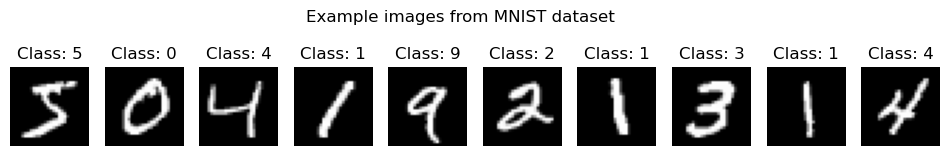

In [27]:
import torch
import numpy as np
from torchvision.transforms import v2
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F

transform = v2.Compose([v2.PILToTensor()])
# Load MNIST dataset
X_train = datasets.MNIST('../data', train=True, download=True)
X_test = datasets.MNIST('../data', train=False, download=True)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input, cmap="gray")
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()
img_size = X_train[0][0].size[0]

In [28]:
from utils import ViT_torch

# Initialize the model and move to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 512
patch_size = 4
num_patches = img_size**2 // patch_size**2
dropout = 0
in_channels = 1 
num_heads = 4
num_encoders = 2
hidden_dim = 256
num_classes = 10


model = ViT_torch(embed_dim, patch_size, num_patches, dropout, in_channels, num_heads, num_encoders, hidden_dim, num_classes).to(device)

# Define optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Data splitting
train_size = int(0.99 * len(X_train))
valid_size = len(X_train) - train_size
X_train, X_valid = torch.utils.data.random_split(X_train, [train_size, valid_size])

# Define the collate function
def collate_fn(batch):
    images, labels = zip(*batch)
    img = np.array([np.asarray(image) for image in images]) / 255.0
    imgs = torch.tensor(img, dtype=torch.float32, device=device).unsqueeze(1)
    labels = torch.tensor(labels, dtype=torch.long, device=device)
    return imgs, labels

# DataLoader creation
batch_size = 16
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
valid_loader = torch.utils.data.DataLoader(X_valid, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [29]:


# Training function
def train(model, train_loader):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        imgs, labels = batch 
        predict = model(imgs)
        
        loss = loss_fn(predict, labels)

        # Zero grad and backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_loader)
    return running_loss

# Validation function
def valid(model, valid_loader):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            imgs, labels = batch 
            predict = model(imgs)
            running_loss += loss_fn(predict, labels).item()

    running_loss /= len(valid_loader)  # average loss of this epoch
    return running_loss



In [30]:
# Training loop
max_epoch = 3
for epoch in range(max_epoch):
    train_loss = train(model, train_loader)
    valid_loss = valid(model, valid_loader)
    print(f"Epoch {epoch + 1}/{max_epoch}, Loss train: {train_loss:.4f}, valid: {valid_loss:.4f}")


100%|██████████| 38/38 [00:02<00:00, 16.51it/s]


Epoch 1/3, Loss train: 2.6754, valid: 2.3125


100%|██████████| 38/38 [00:02<00:00, 14.10it/s]


Epoch 2/3, Loss train: 2.3077, valid: 2.3021


100%|██████████| 38/38 [00:02<00:00, 15.69it/s]

Epoch 3/3, Loss train: 2.3031, valid: 2.2997


torch.Size([1, 512])


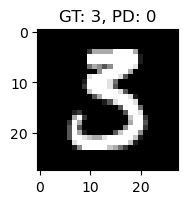

In [33]:
# Select a random sample
model.eval()
sample = next(iter(test_loader))
img, label = sample
# Use the encode and decode functions
pred = model(img)
print(pred.shape)


# Plot the images
plt.figure(figsize=(4, 3))
plt.subplot(1,2,1)
plt.imshow(img.reshape(28, 28), cmap="gray")
plt.title(f"GT: {label.item()}, PD: {0}")
plt.show()